In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [2]:
import time
import numpy as np

# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    plt.title(f"{env.spec.id} | Episode: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def visual_experiment(env, next_action, max_episode_steps=100, max_episodes=3, visualize_in_notebook=True, sleep=0.01):
    episode_rewards = []
    env.reset()

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    for episode in range(1, max_episodes+1):
        # reset env
        time.sleep(1)
        obs = env.reset()
        total_reward = 0.0
        
        for step in range(1, max_episode_steps+1):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            
            if visualize_in_notebook:
                update_fig(img, env, episode, step, total_reward, done)
            else:
                env.render()
            
            if sleep > 0.0:
                time.sleep(sleep)

        episode_rewards.append(total_reward)

    print(f"Rewards: {episode_rewards}")
    print(f"Mean reward of {len(episode_rewards)} episodes: {np.mean(episode_rewards)}")
    print(f"Std reward of {len(episode_rewards)} episodes: {np.std(episode_rewards)}")

In [3]:
def experiment(env, next_action, max_episode_steps=100, max_episodes=3):
    episode_rewards = []
    episode_obs_records = []
    env.reset()

    for episode in range(1, max_episodes+1):
        # reset env
        obs = env.reset()
        total_reward = 0.0
        obs_records = [obs]
        
        for step in range(1, max_episode_steps+1):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            obs_records.append(obs)

        episode_rewards.append(total_reward)
        episode_obs_records.append(obs_records)

    return np.array(episode_rewards), np.array(episode_obs_records)

### Run the env by randoming sampling an action

Rewards: [11.0, 24.0, 24.0]
Mean reward of 3 episodes: 19.666666666666668
Std reward of 3 episodes: 6.128258770283412


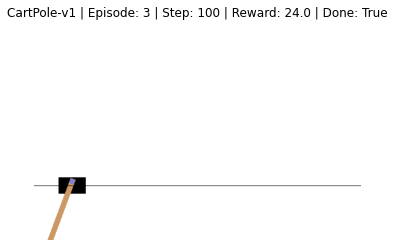

In [4]:
# Run the env by randoming sampling an action
env = gym.make('CartPole-v1')
_ = visual_experiment(env, lambda obs: env.action_space.sample(), sleep=0)

In [5]:
rewards, records = experiment(env, lambda obs: env.action_space.sample(), max_episode_steps=500, max_episodes=10)
env.close()

In [6]:
import pandas as pd
import seaborn as sns

sns.set_style("white", {'axes.spines.right': False, 'axes.spines.top': False})
# sns.set(font_scale=1.2)

def visualize_obs(records):
    if len(records) > 10:
        records = records[np.random.choice(len(records), size=10, replace=False)]
    
    num_episodes = len(records)
    pos_data = pd.DataFrame(records[:, :, 0].T, columns=[f'Ep. {i}' for i in range(1, num_episodes+1)])
    angle_data = pd.DataFrame(records[:, :, 2].T, columns=[f'Ep. {i}' for i in range(1, num_episodes+1)])
    
    _, (pos_ax, angle_ax) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
#     sns.barplot(data=reward_data, ax=axs[0]).set(xlabel="Episode", ylabel="Rewards")

    sns.lineplot(data=pos_data, ax=pos_ax).set(xlabel="Step", ylabel="Position")
#     pos_ax.legend(bbox_to_anchor=(1.35, 0), loc='lower right')
    
    sns.lineplot(data=angle_data*180/np.pi, ax=angle_ax).set(xlabel="Step", ylabel="Angle")
#     angle_ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')

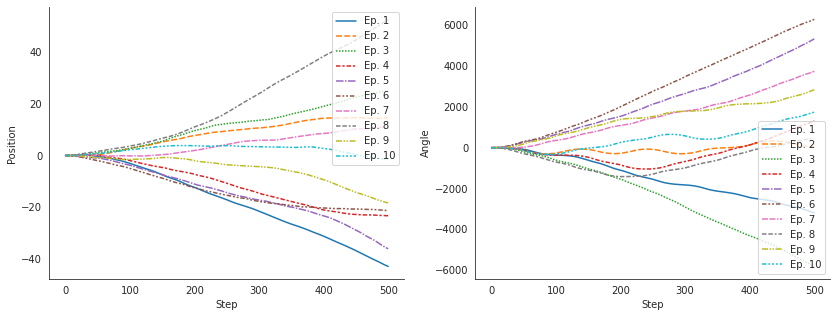

In [7]:
visualize_obs(records)

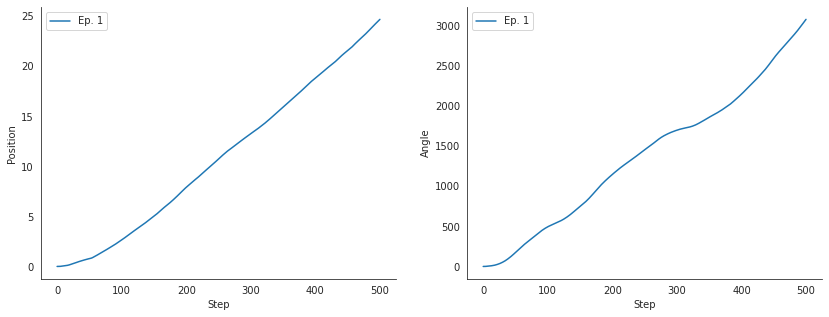

In [8]:
visualize_obs(np.abs(records).mean(axis=0, keepdims=True))

### Run the original env by a trained agent

In [9]:
from stable_baselines3 import PPO

model_ppo = PPO.load("best_model")

In [10]:
env = gym.make('CartPole-v1')
env.seed(1234)
rewards1, records1 = experiment(env, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
env.close()

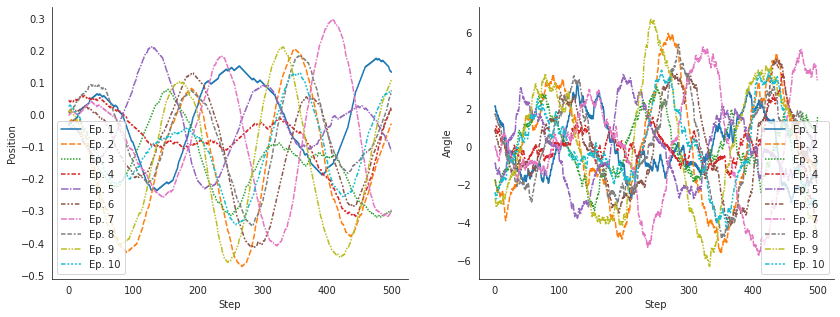

In [11]:
visualize_obs(records1)

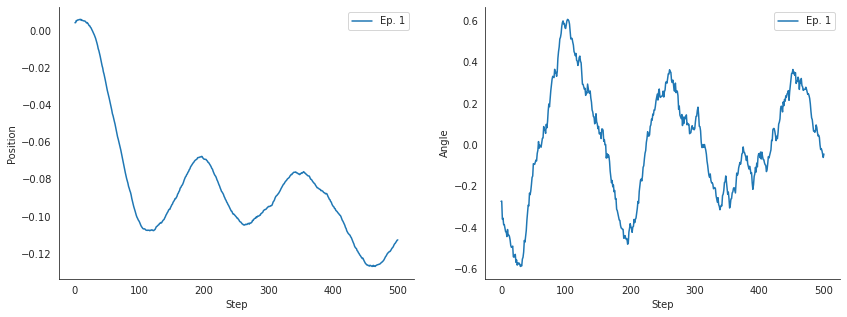

In [12]:
visualize_obs(records1.mean(axis=0, keepdims=True))

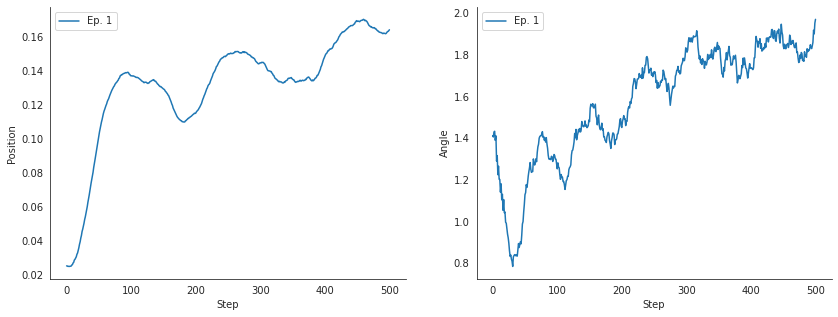

In [13]:
visualize_obs(np.abs(records1).mean(axis=0, keepdims=True))

### Create deviated environment

In [14]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from gym.wrappers.time_limit import TimeLimit
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart}-{masspole}-{length}-{force_mag}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates

In [15]:
mutated_env2 = MutatedCartPoleEnv(masscart=0.5)
mutated_env2.seed(1234)
rewards2, records2 = experiment(mutated_env2, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
mutated_env2.close()

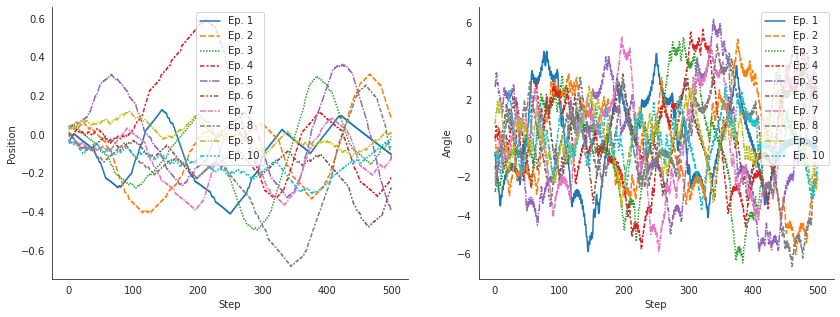

In [16]:
visualize_obs(records2)

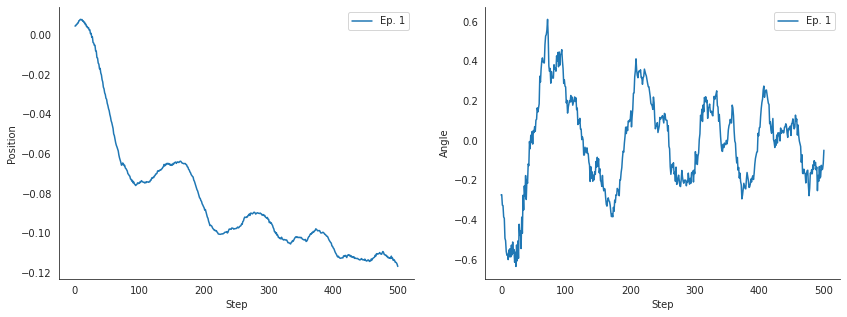

In [17]:
visualize_obs(records2.mean(axis=0, keepdims=True))

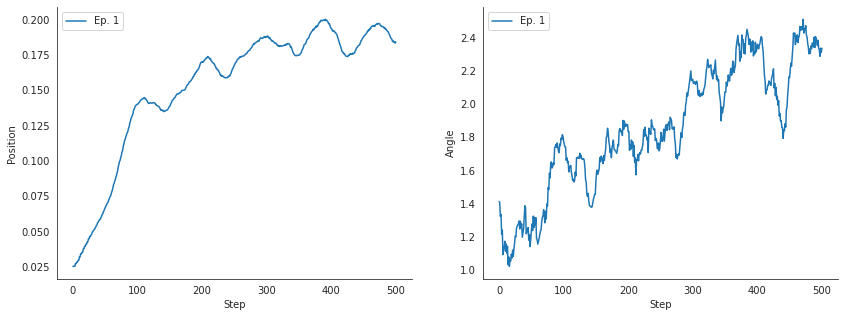

In [18]:
visualize_obs(np.abs(records2).mean(axis=0, keepdims=True))

In [19]:
mutated_env3 = MutatedCartPoleEnv(force_mag=20)
mutated_env3.seed(1234)
rewards3, records3 = experiment(mutated_env3, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
mutated_env3.close()

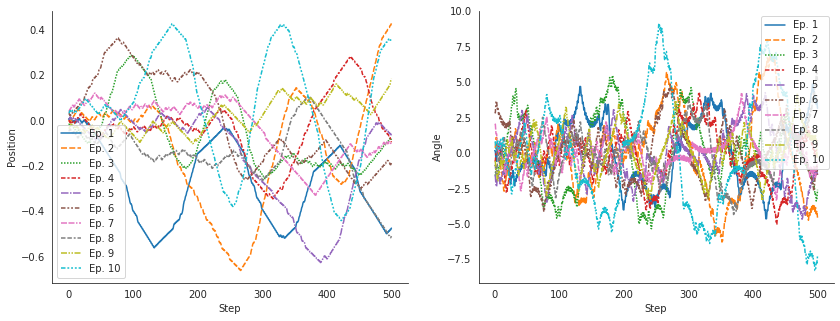

In [20]:
visualize_obs(records3)

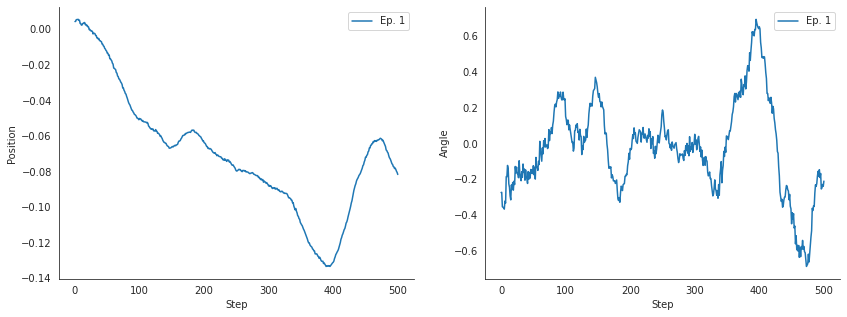

In [21]:
visualize_obs(records3.mean(axis=0, keepdims=True))

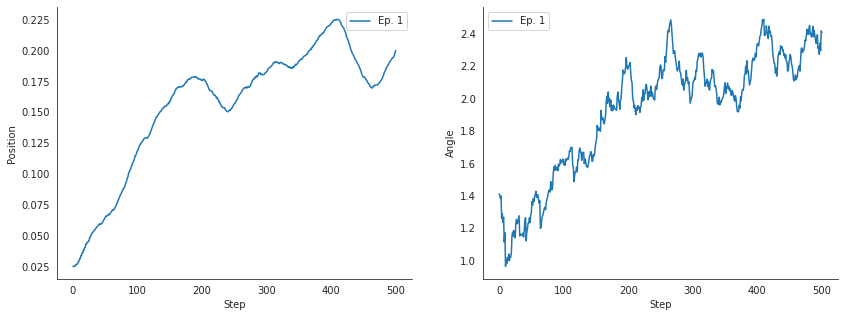

In [22]:
visualize_obs(np.abs(records3).mean(axis=0, keepdims=True))

### Use STL Robustness value

In [23]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

In [24]:
num_episodes = len(records1)
robustness_data = pd.DataFrame(
    np.array([
        compute_STL_robustness(records1),
        compute_STL_robustness(records2),
        compute_STL_robustness(records3)
    ]).T,
    columns=["original", "masscart=0.5", "forcemag=20"],
    index=[f'Ep. {i}' for i in range(1, num_episodes+1)]
)
robustness_data.head()

,original,masscart=0.5,forcemag=20
Ep. 1,0.092259,0.093611,0.090292
Ep. 2,0.119379,0.142608,0.137179
Ep. 3,0.135619,0.141962,0.099177
Ep. 4,0.137875,0.097868,0.068843
Ep. 5,0.154519,0.102630,0.130411


In [25]:
robustness_data.describe()

,original,masscart=0.5,forcemag=20
count,100.000000,100.000000,100.000000
mean,0.133012,0.112644,0.110095
std,0.021374,0.028210,0.024439
min,0.057625,0.041310,0.040209
25%,0.121435,0.096548,0.100469
50%,0.133575,0.113870,0.112111
75%,0.149101,0.135392,0.126938
max,0.175429,0.158546,0.156476


<AxesSubplot:>

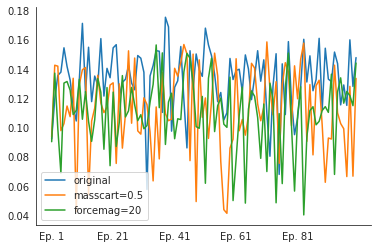

In [26]:
robustness_data.plot()